In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [27]:
%run ./utils.py

# 0. IMPORTING DATA

In [3]:
GLE = get_series("GLE.PA.csv")

In [4]:
print_info_stock(GLE)

nom      : GLE.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


In [5]:
GLE[GLE.isnull()]
GLE = GLE[GLE.notnull()] # some rows have no value for the adjusted close, we delete those rows

# 1. FEATURE ENGINEERING
obj = predict cumulative @ today + 5 five trading days

**FEATURES USED**
- out_to_in_BB: True if the spot price went from outside the Bollinger band to the inside of the Bollinger band
- spike : adjusted close/RM (RM = rolling mean over a window to define)
- pre_spike : adjusted close/RM of the previous trading day
- spike_derivative : difference between the two last features
- crossed_RM_up : yesterday spot was < RM today spot > RM
- crossed_RM_down : yesterday spot was > RM today spot < RM
- mom_1 : cumulative return past day
- mom_5 : cumulative return past 5 days
- mom_10 : cumulative return past 10 days

In [6]:
GLE_df = pd.concat([GLE,df_bollinger_features(GLE,10),df_momentum(GLE),y(GLE)], axis=1)

# 2. ML

In [7]:
X_train, X_test, Y_train, Y_test = split_train_test(GLE_df)

from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,Y_train)
Y_pred = pd.Series(clf.predict(X_test))
Y_pred.index = Y_test.index

/Users/edouardcuny/.pyenv/versions/2.7.10/envs/ml/lib/python2.7/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# 3. RESULTS

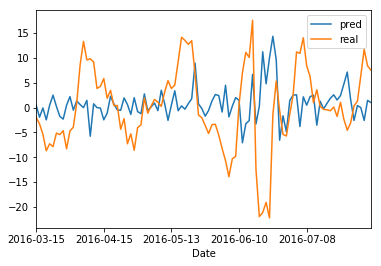


48% of the time we get the direction right

MAE TEST  : 4.28641070874
MSE TEST  : 35.687945144


In [17]:
print_results_report(Y_pred,Y_test)

# 4. LEARNING CURVE 

We use a learning curve to diagnose what went wrong.

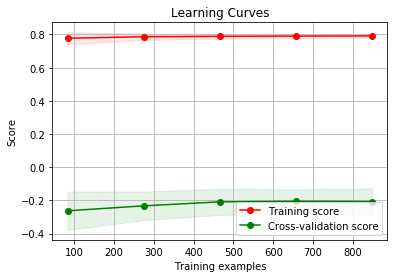

In [22]:
compute_learning_curve(clf,X_train,Y_train)

# MORE DATA

In [28]:
# i want the list of the files from there 
import os
tickers = os.listdir("/Users/edouardcuny/Desktop/quant/Carmela/data2/")
l = []
for ticker in tickers:
    if 'csv' in ticker:
        df = get_df(ticker)
        df.drop(df.columns[0], axis=1,inplace=True)
        l.append(df)

In [31]:
df = pd.concat(l, axis=0)
# df.to_csv("/Users/edouardcuny/Desktop/stocks.csv")

In [33]:
# removing rows w/ infinite
df.replace([np.inf, -np.inf], np.nan,inplace=True)

# removing rows w/ NaN i.e. first rows and last rows based on window_size
df.dropna(inplace=True)

X_train,X_test,Y_train,Y_test = split_train_test(df)

In [34]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,Y_train)
Y_pred = pd.Series(clf.predict(X_test))
Y_pred.index = Y_test.index

In [ ]:
# features rescaling
from sklearn.preprocessing import scale
X.loc[:,'spike'] = scale(X['spike'])
X.loc[:,'pr_spike'] = scale(X['pr_spike'])
X.loc[:,'spike_derivative'] = scale(X['spike_derivative'])
X.loc[:,'mom_1'] = scale(X['mom_1'])
X.loc[:,'mom_5'] = scale(X['mom_5'])
X.loc[:,'mom_10'] = scale(X['mom_10'])

# train & test
split = 0.7 
n = int(0.7*df.shape[0])
X_train = X.iloc[:n,:]
X_test = X.iloc[n:,:]
Y_train = Y[:n]
Y_test = Y[n:]

from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,Y_train)
Y_pred = pd.Series(clf.predict(X_test))
Y_pred.index = Y_test.index
comparison = pd.concat([Y_pred,Y_test],axis=1)
comparison.columns = ['pred','real']

In [ ]:
comparison[300:400].plot()
plt.show()

In [ ]:
direction = sum(comparison.iloc[:,0]*comparison.iloc[:,1]>0)/float(comparison.shape[0])
print str(int(direction*100)) + '% of the time we get the direction right'

In [ ]:
Y_pred_train = pd.Series(clf.predict(X_train))
Y_pred_train.index = Y_train.index
comparison_train = pd.concat([Y_pred_train,Y_train],axis=1)
comparison_train.columns = ['pred','real']
comparison_train[:100].plot()
plt.show()

In [ ]:
print mse(Y_pred,Y_test)
print mae(Y_pred,Y_test)